In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
import matplotlib

In [78]:
from sklearn import metrics

In [79]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [80]:
import xgboost as xgb

In [81]:
# Add higher directory to python modules path.

import sys
sys.path.append("..")

In [82]:
# Local utility functions
from utilities import machine_learning_utils

In [83]:
# ?xgb.DMatrix
# ?xgb.cv

In [84]:
# ?xgb.XGBClassifier

## Load Data

In [85]:
import pickle

X_train,y_train,X_test,y_test,feature_names,words_train_df = pickle.load(open("../../generated_data/word_data_features.p","rb"))

X_train.shape,X_test.shape,feature_names.shape, words_train_df.shape

((35761, 3000), (11921, 3000), (3000,), (35761, 2))

In [86]:
# save original variables just in case
X_train0,y_train0 = X_train,y_train

In [87]:
# Create the DMatrices for our data
DMat_train = xgb.DMatrix(data=X_train, label=pd.Series(y_train).map({"MSA":0, "TND":1}).tolist())
DMat_test = xgb.DMatrix(data=X_test, label=pd.Series(y_test).map({"MSA":0, "TND":1}).tolist())

## Build default model

In [88]:
xgb1 = xgb.XGBClassifier(
 learning_rate =0.3,
 n_estimators=500,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 scale_pos_weight=1,
 objective= 'binary:logistic',
 nthread=4,
 seed=27)

In [89]:
xgb1.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.3,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 500,
 'n_jobs': 1,
 'nthread': 4,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 27,
 'silent': True,
 'subsample': 0.8}

In [90]:
xgb1.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.3,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 500,
 'nthread': 4,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 27,
 'silent': 1,
 'subsample': 0.8}

In [91]:
# TEMPORARY FOR DEBUGGING

xgb1.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)

In [92]:
# Predict the labels of the test set
y_test_pred = xgb1.predict(X_test)
p_test_pred = xgb1.predict_proba(X_test)[:,1]

# Compute the accuracy: accuracy
accuracy = float(np.sum(y_test_pred==y_test))/y_test.shape[0]
print("accuracy: %f" % (accuracy))

#Print model report
print ("\nModel Report")
print ("Accuracy: %.4g" % metrics.accuracy_score(y_test, y_test_pred))
print ("AUC Score: %f" % metrics.roc_auc_score(y_test, p_test_pred))

accuracy: 0.983307

Model Report
Accuracy: 0.9833
AUC Score: 0.892266


------------------------------------
Classification report with default cutoff threshold=0.5
------------------------------------

              precision    recall  f1-score   support

         MSA       0.99      1.00      0.99     11724
          TN       0.48      0.11      0.17       197

   micro avg       0.98      0.98      0.98     11921
   macro avg       0.73      0.55      0.58     11921
weighted avg       0.98      0.98      0.98     11921

Average F1 score: 0.582921006406473

Confusion matrix:
col_0    MSA  TN
row_0           
MSA    11701  23
TN       176  21


------------------------------------
Area Under the Curve:  0.892
------------------------------------



------------------------------------
Maximum F1 Scores:
------------------------------------
               MSA        TN   Average
Threshold  0.93976  0.089801  0.091264
Max(F1)    0.99192  0.332657  0.659367

------------------------------------



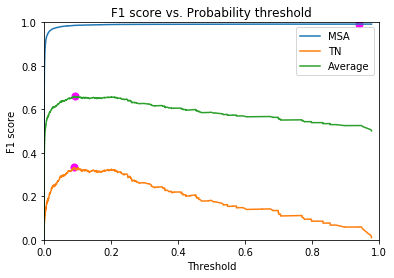

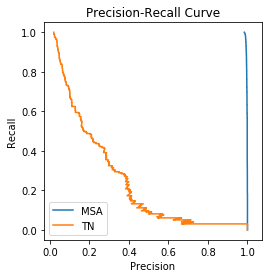

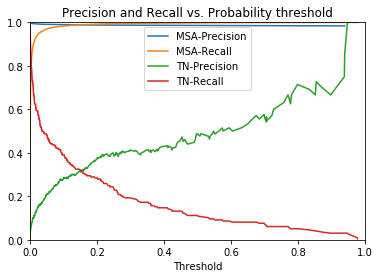

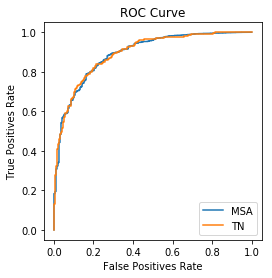

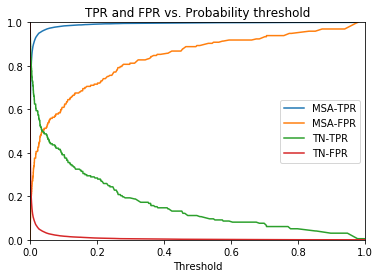

In [93]:
machine_learning_utils.my_performance_report(y_test,xgb1.predict(X_test),xgb1.predict_proba(X_test),xgb1.classes_)

*****

## Hyperparameter tuning

This part is currently disfunctional: xgb.cv() crashes because the matrix is too large. Need to fix this somehow ...

*General strategy for tuning hyperparameters of XGboost*:

1. **Choose a relatively high learning rate and find optimum number of trees for this learning rate**. Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. XGBoost has a very useful function called as “cv” which performs cross-validation at each boosting iteration and thus returns the **optimum number of trees**.
2. **Tune tree-specific parameters** (max_depth, min_child_weight, gamma, subsample, colsample_bytree) for the chosen learning rate and number of trees.
3. **Tune regularization parameters** (lambda, alpha) which can help reduce model complexity and enhance performance. [in order to reduce overfitting???]
4. **Tune the learning rate** : find a lower learning rate ...

Reference: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

### Step 1

**Choose a relatively high learning rate and find optimum number of trees for this learning rate**.

- learning rate = 0.1
- max_depth = 5 : This should be between 3-10.
- min_child_weight = 1 : choose a relatively small value because we have a highly imbalanced class problem and leaf nodes can have small size groups.
- gamma = 0 : A small value like 0.1-0.2 can also be chosen as a starting point. This will anyways be tuned later.
- subsample, colsample_bytree = 0.8 : These are good starting values. Typical values range between 0.5-0.9.
- scale_pos_weight = 1 : Because of high class imbalance.

In [ ]:
# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=DMat_train, params=xgb1.get_xgb_params(), 
                    num_boost_round=xgb1.get_params()['n_estimators'], early_stopping_rounds=50, 
                    nfold=5, metrics="error", 
                    stratified=True,
                    as_pandas=True, verbose_eval=False, seed=123)

# print(cv_results)

print("classification error in final round:", cv_results["test-error-mean"].iloc[-1])
print("number of estimators:", cv_results.shape[0])

# Plot accuracy
cv_results[["train-error-mean","test-error-mean"]].plot()
cv_results[["train-error-std","test-error-std"]].plot()

In [ ]:
# Perform cross_validation with AUC metric

cv_results1_ = xgb.cv(dtrain=DMat_train, params=xgb1.get_xgb_params(), 
                    num_boost_round=xgb1.get_params()['n_estimators'], early_stopping_rounds=50, 
                    nfold=5, metrics="auc", 
                    stratified=True,
                    as_pandas=True, verbose_eval=False, seed=123)

print("AUC in final round:", cv_results1_["test-auc-mean"].iloc[-1])

print("number of estimators:", cv_results1_.shape[0])

cv_results1_[["train-auc-mean","test-auc-mean"]].plot()

cv_results1_[["train-auc-std","test-auc-std"]].plot()

### Step 2

**Tune tree-specific parameters** (max_depth, min_child_weight, gamma, subsample, colsample_bytree) for the chosen learning rate and number of trees.

- Step 2.1: use grid search to tune `max_depth` and `min_child_weight`.
- Step 2.2: 

In [ ]:
xgb2 = xgb1
xgb2.set_params(n_estimators=100)

In [ ]:
xgb2.get_params()

In [ ]:
xgb2.get_xgb_params()

In [ ]:
param_grid1 = {
 'max_depth':range(1,6,1),
 'min_child_weight':range(1,6,1)
}

gsearch1 = GridSearchCV(estimator=xgb2, param_grid=param_grid1, scoring='roc_auc', n_jobs=4, iid=False, cv=5, return_train_score=True)
gsearch1.fit(X_train,y_train)

In [ ]:
print("Best score:", gsearch1.best_score_)
print("Best parameters:", gsearch1.best_params_)

res_df = pd.DataFrame(gsearch1.cv_results_)
res_df = res_df.set_index(['param_max_depth','param_min_child_weight'])
res_df = res_df[['mean_test_score','std_test_score','mean_train_score','std_train_score']]

print(res_df.head())

res_df[['mean_train_score','mean_test_score']].plot()

#pd.DataFrame(gsearch1.cv_results_['params']).head()
#gsearch1.best_estimator_

In [ ]:
{'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)],
 'subsample': [i/100.0 for i in range(75,90,5)],
 'colsample_bytree': [i/100.0 for i in range(75,90,5)] }

In [ ]:
param_grid2 = {
    'max_depth':[3,4,5],
    'min_child_weight':[1,2],
    'subsample': [0.5,0.7,0.9,1.0],
    'colsample_bytree':[0.5,0.7,0.9,1.0],
    'gamma':[i/10.0 for i in range(0,8)]
}

In [ ]:
gsearch2 = GridSearchCV(estimator=xgb2, param_grid=param_grid2, scoring='roc_auc', 
                        n_jobs=4, iid=False, cv=5, return_train_score=True)
gsearch2.fit(X_train,y_train)

print("Best score:", gsearch2.best_score_)
print("Best parameters:", gsearch2.best_params_)

res_df2 = pd.DataFrame(gsearch2.cv_results_)
res_df2 = res_df2.set_index(['param_max_depth','param_min_child_weight','param_subsample','param_colsample_bytree','param_gamma'])
res_df2 = res_df2[['mean_test_score','std_test_score','mean_train_score','std_train_score']]

print(res_df2.head())

res_df2[['mean_train_score','mean_test_score']].plot()

In [ ]:
gsearch2b = RandomizedSearchCV(estimator=xgb2, param_distributions=param_grid2, scoring='roc_auc', 
                              n_iter = 30,
                              n_jobs=4, iid=False, cv=5, return_train_score=True)
gsearch2b.fit(X_train,y_train)

print("Best score:", gsearch2b.best_score_)
print("Best parameters:", gsearch2b.best_params_)

res_df2b = pd.DataFrame(gsearch2b.cv_results_)
res_df2b = res_df2b.set_index(['param_max_depth','param_min_child_weight'])
res_df2b = res_df2b[['mean_test_score','std_test_score','mean_train_score','std_train_score']]

print(res_df2b.head())

res_df2b[['mean_train_score','mean_test_score']].plot()


### Step 3

**Tune regularization parameters** (lambda, alpha) which can help reduce model complexity and enhance performance.

In [ ]:
gsearch2.best_params_

In [ ]:
xgb3 = xgb2
xgb3.set_params(colsample_bytree=0.5,max_depth=4,min_child_weight=1,subsample=1.0,gamma=0.5)

In [ ]:
xgb3.get_params()

In [ ]:
xgb3.get_xgb_params()

In [ ]:
param_grid3 = {
    'reg_lambda':[1e-5, 1e-2, 0.1, 1, 10],
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 10],
}

In [ ]:
gsearch3 = GridSearchCV(estimator=xgb3, param_grid=param_grid3, scoring='roc_auc', 
                        n_jobs=4, iid=False, cv=5, return_train_score=True)
gsearch3.fit(X_train,y_train)

In [ ]:
print("Best score:", gsearch3.best_score_)
print("Best parameters:", gsearch3.best_params_)

res_df3 = pd.DataFrame(gsearch3.cv_results_)
res_df3 = res_df3.set_index(['param_reg_lambda','param_reg_alpha'])
res_df3 = res_df3[['mean_test_score','std_test_score','mean_train_score','std_train_score']]

res_df3[['mean_train_score','mean_test_score']].plot()

In [ ]:
res_df3.head()

In [ ]:
res_df3.tail()

In [ ]:
param_grid3b = {
    'reg_lambda':[0.1, 0.5, 0.7, 1, 2, 5],
    'reg_alpha':[1e-6, 5e-6, 1e-5, 5e-5, 1e-4],
}

In [ ]:
gsearch3b = GridSearchCV(estimator=xgb3, param_grid=param_grid3b, scoring='roc_auc', 
                        n_jobs=4, iid=False, cv=5, return_train_score=True)
gsearch3b.fit(X_train,y_train)

In [ ]:
print("Best score:", gsearch3b.best_score_)
print("Best parameters:", gsearch3b.best_params_)

res_df3b = pd.DataFrame(gsearch3b.cv_results_)
res_df3b = res_df3b.set_index(['param_reg_lambda','param_reg_alpha'])
res_df3b = res_df3b[['mean_test_score','std_test_score','mean_train_score','std_train_score']]

res_df3b[['mean_train_score','mean_test_score']].plot()
res_df3b[['std_train_score','std_test_score']].plot()

In [ ]:
res_df3b.head(10)

### Step 4

In [ ]:
xgb4 = xgb3
xgb4.set_params(reg_alpha=5e-05, reg_lambda=1.0)

In [ ]:
param_grid4 = {
    'scale_pos_weight':[0.6,0.7,0.8,0.9,1.0]
}

In [ ]:
gsearch4 = GridSearchCV(estimator=xgb4, param_grid=param_grid4, scoring='roc_auc', 
                        n_jobs=4, iid=False, cv=5, return_train_score=True)
gsearch4.fit(X_train,y_train)

In [ ]:
print("Best score:", gsearch4.best_score_)
print("Best parameters:", gsearch4.best_params_)

res_df4 = pd.DataFrame(gsearch4.cv_results_)
res_df4 = res_df4.set_index('param_scale_pos_weight')
res_df4 = res_df4[['mean_test_score','std_test_score','mean_train_score','std_train_score']]

res_df4[['mean_train_score','mean_test_score']].plot()

In [ ]:
res_df4[['mean_train_score','mean_test_score']].head()

## Build Final XGBoost Model

In [ ]:
xgb_final = xgb4
xgb_final.set_params(scale_pos_weight=1.0)

In [ ]:
# Perform cross_validation with AUC metric

cv_results_final = xgb.cv(dtrain=DMat_train, params=xgb_final.get_xgb_params(), 
                    num_boost_round=xgb_final.get_params()['n_estimators'], early_stopping_rounds=50, 
                    nfold=5, metrics="auc", 
                    stratified=True,
                    as_pandas=True, verbose_eval=False, seed=123)

print("AUC in final round:", cv_results_final["test-auc-mean"].iloc[-1])

print("number of estimators:", cv_results_final.shape[0])

cv_results_final[["train-auc-mean","test-auc-mean"]].plot()

cv_results_final[["train-auc-std","test-auc-std"]].plot()

### Model performance on test set

In [ ]:
# Fit the classifier to the training set
xgb_final.fit(X_train,y_train)

In [ ]:
# Predict the labels of the test set
y_test_pred = xgb_final.predict(X_test)
p_test_pred = xgb_final.predict_proba(X_test)[:,1]

# Compute the accuracy: accuracy
accuracy = float(np.sum(y_test_pred==y_test))/y_test.shape[0]
print("accuracy: %f" % (accuracy))

#Print model report
print ("\nModel Report")
print ("Accuracy: %.4g" % metrics.accuracy_score(y_test, y_test_pred))
print ("AUC Score: %f" % metrics.roc_auc_score(y_test, p_test_pred))

In [ ]:
machine_learning_utils.my_performance_report(y_test,xgb_final.predict(X_test),xgb_final.predict_proba(X_test),xgb_final.classes_)

### Feature importance

Get top 20 most important features.

References: 

- https://stackoverflow.com/questions/38212649/feature-importance-with-xgbclassifier  (Jul 2016)
- https://stackoverflow.com/questions/51905524/plot-importance-variables-xgboost-python  (Aug 2018)

In [ ]:
xgb_final.booster

In [ ]:
## Method 1
# Reference: https://stackoverflow.com/questions/38212649/feature-importance-with-xgbclassifier  (Jul 2016)
    
def get_xgb_imp(xgb, feat_names):
    from numpy import array
    imp_dict = xgb.get_booster().get_fscore()
    #df = pd.Series(imp_dict)
    df = pd.DataFrame(imp_dict.items())
    df.columns = ['fidx','importance_score']
    df['idx'] = df.fidx.map(lambda x: int(x[1:]))
    df['ngram'] = df.fidx.map(lambda x: feat_names[int(x[1:])])
    df = df.set_index('idx')
    return df
feat_imp_df = get_xgb_imp(xgb_final,feature_names)
feat_imp_df.sort_values(by='importance_score',ascending=False, inplace=True)
feat_imp_df.head()

In [ ]:
feat_imp_df.head(10)

In [ ]:
feat_imp_df.sort_index().head()

In [ ]:
list(feat_imp_df.ngram[0:10])

In [ ]:
#?feat_imp_df.plot.barh

In [ ]:
feat_imp_df.head(10).plot.barh(y='importance_score', x='ngram', title='Feature Importances')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature Name (ngram)')
plt.title('Top 10 Features')

In [ ]:
## Method 2
# Reference: https://stackoverflow.com/questions/51905524/plot-importance-variables-xgboost-python  (Aug 2018)

from xgboost import plot_importance
plot_importance(xgb_final, max_num_features=10)
plt.show()

In [ ]:
def analyze_feature_importance_v2(feat_imp_df,train_words_df,X_train):

    assert(train_words_df.shape[0]==X_train.shape[0] and feat_imp_df.shape[0]<=X_train.shape[1])

    # print top 10 features
    print("Top 10 Features:")
    print("Importance_score\tNgram_feature")
    for i in feat_imp_df.index[0:10]:
        ##print("\t", feat_imp_df.importance_score[i], '\t\t\t\"'+feat_imp_df.ngram[i]+'\"')
        print('%10.2f\t\t\"%s\"' %(feat_imp_df.importance_score[i],feat_imp_df.ngram[i]))
    print("")

    ## relationship of the top 10 features with the training words

    for i in feat_imp_df.index[0:10]:
        print("=====================")
        print("feature:", '\"'+feat_imp_df.ngram[i]+'\"')
        print("")
        u = X_train[:,i].toarray().ravel()
        print("Number of training words that contain this feature:",(u>0).sum())
        print("")
        df1 = train_words_df.loc[u>0,'lang_label'].value_counts(normalize=False)
        df2 = train_words_df['lang_label'].value_counts(normalize=False)
        df3 = df1/df2*100
        df3.index = df1.index
        df4 = pd.concat([df1,df2,df3],axis=1, sort=False)
        df4.columns = ['contain this feature', 'total', '% of total']
        print("Distribution of language labels of words that contain this feature:")
        print(df4)
        print("")
        print("Example training words that contain this feature:")
        print("  MSA:",train_words_df.loc[(u>0)&(train_words_df.lang_label=="MSA"),'word'].head(10).tolist())
        print("  TND:",train_words_df.loc[(u>0)&(train_words_df.lang_label=="TND"),'word'].head(10).tolist())
        print("")

In [ ]:
analyze_feature_importance_v2(feat_imp_df,words_train_df,X_train)

*****